# Wetland histograms

**Background**

**What does this notebook do?** This notebook generates histograms of raster properties for wetland and non-wetland regions in Queensland.

**Date**: Aug 2020.

**Author**: Matthew Alger

## Setup

Set up the notebook and load the data.

In [1]:
import functools
from multiprocessing.pool import Pool
import multiprocessing
import os
import sys
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
import rasterio.mask
from shapely.geometry import shape
from shapely.validation import explain_validity
import skimage.color as colour
import skimage.io
from tqdm.notebook import tqdm
import xarray

sys.path.append('../Scripts')
from dea_dask import create_local_dask_cluster
from dea_datahandling import load_ard, array_to_geotiff
from dea_plotting import rgb

/g/data/v10/public/modules/dea/20200617/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [3]:
tcw_conf = '/g/data/r78/datacube_stats/ls_tcw_percentiles/vmn547_cog_dev.conf'
dc = datacube.Datacube(config=tcw_conf)

In [4]:
wetlands = gpd.read_file('/g/data/r78/ma6611/Queensland_dominant_wetland_areas_22042020.shp')

In [5]:
tiles = gpd.read_file('QLDTestTiles.shp')

In [6]:
validity = wetlands.geometry.apply(lambda k: explain_validity(k) if k is not None else None)

In [7]:
invalid = validity != 'Valid Geometry'

In [8]:
# Fix invalid geometries.
fixed_wetlands = wetlands[invalid].geometry.buffer(0)
wetlands_original = wetlands
wetlands = wetlands.copy()
wetlands.loc[invalid, 'geometry'] = fixed_wetlands

## Calculate histograms

In [ ]:
sampled_wetlands = wetlands.geometry.intersection(tiles.unary_union)

In [ ]:
wetlands = wetlands[~sampled_wetlands.geometry.is_empty]
wetlands.loc[:, 'geometry'] = sampled_wetlands[~sampled_wetlands.geometry.is_empty]

In [ ]:
# Here's some ways to get the "non-wetlands" regions that we have tiles for.
# Super super slow! Don't do this.
# Better approach is to load the raster images that we have and then mask the wetlands.

# sampled_nonwetlands = tiles.copy()
# for i in tqdm(range(len(sampled_wetlands))):
#     sampled_nonwetlands = sampled_nonwetlands.difference(wetlands.iloc[i])

# sampled_nonwetlands = gpd.overlay(tiles, wetlands, how='difference')

In [ ]:
def get_tcw(tile_label):
    tif_path_base = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_wetness/LS_TCW_PC_{}_1986_2020_summary.tif'
    tif_path = tif_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_rasterio(tif_path)
    return da

def get_tcg(tile_label):
    tif_path_base = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_greenness/LS_TCG_PC_{}_1986_2020_summary.tif'
    tif_path = tif_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_rasterio(tif_path)
    return da

def make_wetland_mask(da):
    raster_wetland = rasterio.features.rasterize(shapes=wetlands.buffer(0),
                                                 out_shape=da.y.shape + da.x.shape,
                                                 all_touched=False,
                                                 default_value=1,
                                                 fill=0,
                                                 transform=da.geobox.transform)
    return raster_wetland.astype(bool)

In [ ]:
def get_tc_histograms(tile_label, tc='w', band=3, bins=None) -> ('wetland', 'nonwetland'):
    if tc == 'w':
        get = get_tcw
    elif tc == 'g':
        get = get_tcg
    else:
        raise NotImplementedError(f'Unsupported TC type: {tc} (supported: w, g)')

    da = get(tile_label)
    # Rasterise this tile of wetlands so we can quickly mask.
    wetlands_mask = make_wetland_mask(da)
    # Apply the mask and get the TC data.
    tc_data = da.isel(band=band).values
    nodata = tc_data == da.nodatavals[band]
    tc_data_w = tc_data[wetlands_mask & ~nodata]
    tc_data_nw = tc_data[~wetlands_mask & ~nodata]
    
    if bins is None:
        # Just return the data. Big!
        return tc_data_w, tc_data_nw
    
    # Return a histogram of the data.
    hist_wetland, bin_edges = np.histogram(tc_data_w, bins=bins)
    assert (bin_edges == bins).all()
    hist_nonwetland, bin_edges = np.histogram(tc_data_nw, bins=bins)
    return (hist_wetland, hist_nonwetland)

In [ ]:
px_to_km2 = 0.0001 # 10 m x 10 m -> 100 m^2 = 0.0001 km^2

In [ ]:
def get_wetlands_histograms(tc='w', band=3, bins=None):
    if bins is None:
        bins = np.linspace(-4000, 4000, 120)
    hist_wetland = np.zeros(len(bins) - 1, dtype=int)
    hist_nonwetland = np.zeros(len(bins) - 1, dtype=int)
    for tile in tqdm(tiles.itertuples(), total=len(tiles)):
        hist_wetland_, hist_nonwetland_ = get_tc_histograms(tile.label, tc=tc, band=band, bins=bins)
        hist_wetland += hist_wetland_
        hist_nonwetland += hist_nonwetland_
    return hist_wetland, hist_nonwetland

In [ ]:
def plot_wetlands_histogram(hist_wetland, hist_nonwetland, xlabel, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    ax.bar(bins[:-1], hist_wetland * px_to_km2, width=bins[1] - bins[0], color='blue')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Total wetland area (km$^2$)', fontdict={'color': 'blue'})
    ax.tick_params(axis='y', colors='blue')
    ax2 = ax.twinx()
    ax2.bar(bins[:-1], hist_nonwetland * px_to_km2, width=bins[1] - bins[0], color='red', alpha=0.8)
    ax2.set_ylabel('Total non-wetland area (km$^2$)', fontdict={'color': 'red'})
    ax2.tick_params(axis='y', colors='red')

#     lines, labels = ax.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax2.legend(lines + lines2, labels + labels2, loc=0)

    if ax is None:
        return fig

In [ ]:
bins = np.linspace(-4000, 4000, 120)
hist_wetland_w95, hist_nonwetland_w95 = get_wetlands_histograms('w', 3, bins=bins)
plot_wetlands_histogram(hist_wetland_w95, hist_nonwetland_w95, 'TCW 95');

In [ ]:
bins = np.linspace(-4000, 4000, 120)
hist_wetland_g50, hist_nonwetland_g50 = get_wetlands_histograms('g', 1, bins=bins)
plot_wetlands_histogram(hist_wetland_g50, hist_nonwetland_g50, 'TCG 50');

In [59]:
def get_tc_data_2d(tile_label, tcs=('w', 'g'), bands=(3, 1), bins=None) -> ('wetland', 'nonwetland'):
    for tc in tcs:
        if tc not in 'wg':
            raise NotImplementedError(f'Unsupported TC type: {tc} (supported: w, g)')

    gets = {'w': get_tcw, 'g': get_tcg}
    
    data_w = []
    data_nw = []
    for tc, band in zip(tcs, bands):
        get = gets[tc]
        da = get(tile_label)
        # Rasterise this tile of wetlands so we can quickly mask.
        wetlands_mask = make_wetland_mask(da)
        # Apply the mask and get the TC data.
        tc_data = da.isel(band=band).values
        nodata = tc_data == da.nodatavals[band]
        tc_data_w = tc_data[wetlands_mask & ~nodata]
        tc_data_nw = tc_data[~wetlands_mask & ~nodata]
        data_w.append(tc_data_w)
        data_nw.append(tc_data_nw)
    
    if bins is None:
        # Just return the data. Big!
        return data_w, data_nw

    # Return a histogram of the data.
    hist_wetland, bin_edges_x, bin_edges_y = np.histogram2d(data_w[0], data_w[1], bins=bins)
    hist_nonwetland, bin_edges_x, bin_edges_y = np.histogram2d(data_nw[0], data_nw[1], bins=bins)
    return (hist_wetland, hist_nonwetland)

In [84]:
bins_w = np.linspace(-4000, 4000, 120)
bins_g = np.linspace(-1000, 3000, 120)

hist_wetland_2d = np.zeros((len(bins_w) - 1, len(bins_g) - 1))
hist_nonwetland_2d = np.zeros_like(hist_wetland_2d)

for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    try:
        hist_wetland_2d_, hist_nonwetland_2d_ = get_tc_data_2d(tile.label, bins=(bins_w, bins_g), bands=(3, 0))
    except:
        # no data yet
        continue
    hist_wetland_2d += hist_wetland_2d_
    hist_nonwetland_2d += hist_nonwetland_2d_

RasterioIOError: /g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_greenness/LS_TCG_PC_7_-28_1986_2020_summary.tif: No such file or directory

(-1000.0, 3000.0)

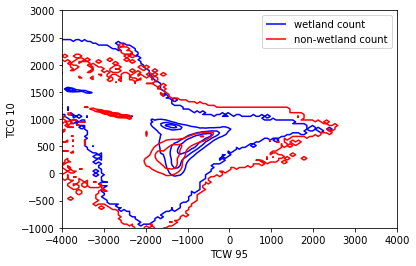

In [86]:
hw = plt.contour(bins_w[:-1], bins_g[:-1], hist_wetland_2d, colors='blue')
hnw = plt.contour(bins_w[:-1], bins_g[:-1], hist_nonwetland_2d, colors='red')
plt.legend([hw.collections[0], hnw.collections[0]], ['wetland count', 'non-wetland count'])
plt.xlabel('TCW 95')
plt.ylabel('TCG 10')
plt.xlim(bins_w.min(), bins_w.max())
plt.ylim(bins_g.min(), bins_g.max())

How does the TCW histogram vary with Koppen climate zone? We use the Koppen maps from Beck, H.E., N.E. Zimmermann, T.R. McVicar, N. Vergopolan, A. Berg, E.F. Wood: Present and future Köppen-Geiger climate classification maps at 1-km resolution, Scientific Data 5:180214, doi:10.1038/sdata.2018.214 (2018).


In [16]:
koppen = xarray.open_rasterio('/g/data/r78/ma6611/Beck_KG_V1_present_0p0083.tif')  # 1km resolution

In [17]:
koppen = koppen.load()

In [18]:
climate_zone_labels = {
    1: 'Af',
    2: 'Am',
    3: 'Aw',
    4: 'BWh',
    5: 'BWk',
    6: 'BSh',
    7: 'BSk',
    8: 'Csa',
    9: 'Csb',
    10: 'Csc',
    11: 'Cwa',
    12: 'Cwb',
    13: 'Cwc',
    14: 'Cfa',
    15: 'Cfb',
    16: 'Cfc',
    17: 'Dsa',
    18: 'Dsb',
    19: 'Dsc',
    20: 'Dsd',
    21: 'Dwa',
    22: 'Dwb',
    23: 'Dwc',
    24: 'Dwd',
    25: 'Dfa',
    26: 'Dfb',
    27: 'Dfc',
    28: 'Dfd',
    29: 'ET',
    30: 'EF',
    0: 'Ocean',
}

In [19]:
def get_koppen_tile(da):
    dest = np.zeros(da.shape[1:])
    src_transform = rasterio.transform.Affine(*koppen.transform)
    koppen_tile = rasterio.warp.reproject(
        koppen.values, dest, src_crs=koppen.crs, dst_crs='EPSG:3577', src_transform=src_transform,
        dst_transform=da.transform)
    return koppen_tile[0].astype(int)

In [20]:
def get_tc_data_and_mask(tile_label, tc='w', band=3) -> ('array', 'wetland mask', 'nonwetland mask'):
    if tc == 'w':
        get = get_tcw
    elif tc == 'g':
        get = get_tcg
    else:
        raise NotImplementedError(f'Unsupported TC type: {tc} (supported: w, g)')

    da = get(tile_label)
    # Rasterise this tile of wetlands so we can quickly mask.
    wetlands_mask = make_wetland_mask(da)
    # Apply the mask and get the TC data.
    tc_data = da.isel(band=band).values
    nodata = tc_data == da.nodatavals[band]
    return da, wetlands_mask & ~nodata, ~wetlands_mask & ~nodata

In [21]:
def proc_tile(tile_label, tc, band, bins):
    da, mask_w, mask_nw = get_tc_data_and_mask(tile_label, tc=tc, band=band)
    koppen_hist_wetland_wet_95 = {}
    koppen_hist_nonwetland_wet_95 = {}

    # Split up by Koppen climate zone.
    # *something* here isn't threadsafe; I think it's the Koppen reprojection.
    # TODO: use a multiprocessing.Lock to force sync it.
    koppen_tile = xarray.DataArray(get_koppen_tile(da), coords=(da.y, da.x))
    koppen_vals = np.unique(koppen_tile.values)

    for v in koppen_vals:
        koppen_hist_wetland_wet_95[v] = np.histogram(da.isel(band=band).values[mask_w & (koppen_tile == v)], bins)[0]
        koppen_hist_nonwetland_wet_95[v] = np.histogram(da.isel(band=band).values[mask_nw & (koppen_tile == v)], bins)[0]

    return koppen_hist_wetland_wet_95, koppen_hist_nonwetland_wet_95

def koppen_hist(tc='w', band=3, bins=None):
    if bins is None:
        bins = np.linspace(-4000, 4000, 120)
    
    with Pool(4) as pool:
        params = [(t.label, tc, band, bins) for t in tiles.itertuples()]
        results = [pool.apply_async(proc_tile, p) for p in params]
        # pool.map fails in a notebook environment.
        hist_results = [r.get() for r in tqdm(results)]
    
    koppen_hist_wetland_wet_95, koppen_hist_nonwetland_wet_95 = {}, {}
    for rw, rnw in hist_results:
        for k, v in rw.items():
            if k in koppen_hist_wetland_wet_95:
                koppen_hist_wetland_wet_95[k] += v
            else:
                koppen_hist_wetland_wet_95[k] = v
        for k, v in rnw.items():
            if k in koppen_hist_nonwetland_wet_95:
                koppen_hist_nonwetland_wet_95[k] += v
            else:
                koppen_hist_nonwetland_wet_95[k] = v
    
    return koppen_hist_wetland_wet_95, koppen_hist_nonwetland_wet_95

In [34]:
bins = np.linspace(-4000, 4000, 120)
koppen_hist_wetland_wet_95, koppen_hist_nonwetland_wet_95 = koppen_hist(bins=bins)

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

In [ ]:
# 3D plot: cool, but hard to read for lots of zones.
# %matplotlib widget
# n_zones = len(koppen_hist_wetland_wet_95)
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# for i, zone in enumerate(sorted(koppen_hist_wetland_wet_95)):
#     ax.bar(bins[:-1], koppen_hist_wetland_wet_95[zone] / (koppen_hist_wetland_wet_95[zone].max() + 1),
#            width=bins[1] - bins[0], color='blue', alpha=0.5, zs=i, zdir='y', edgecolor='None')
#     ax.bar(bins[:-1], koppen_hist_nonwetland_wet_95[zone] / (koppen_hist_nonwetland_wet_95[zone].max() + 1),
#            width=bins[1] - bins[0], color='red', alpha=0.5, zs=i + 0.1, zdir='y', edgecolor='None')
# ax.set_xlabel('TCW 95')
# ax.set_zlabel('Density')
# ax.set_ylabel('Köppen climate zone')
# ticks = ax.set_yticks(range(n_zones))
# ax.set_yticklabels([climate_zone_labels[k] for k in sorted(koppen_hist_wetland_wet_95)])
# plt.tight_layout()

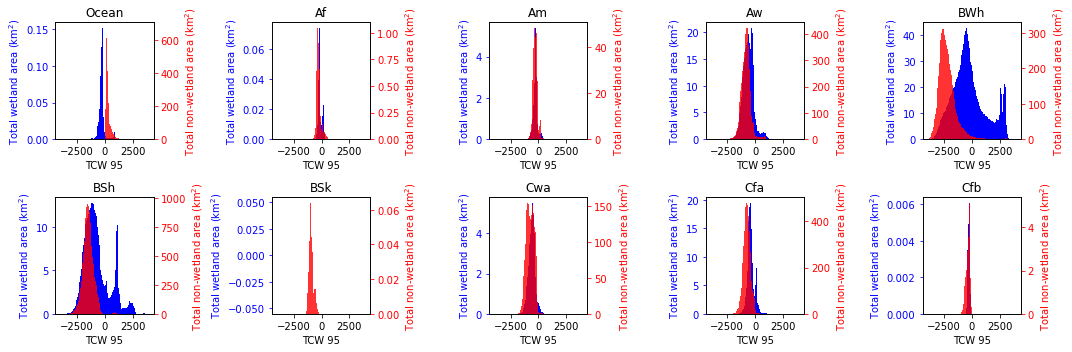

In [37]:
%matplotlib inline
n_zones = len(koppen_hist_wetland_wet_95)
assert n_zones == 10  # Just for the subplot shapes :)
fig = plt.figure(figsize=(15, 5))
for i, zone in enumerate(sorted(koppen_hist_wetland_wet_95)):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(climate_zone_labels[zone])
    plot_wetlands_histogram(koppen_hist_wetland_wet_95[zone], koppen_hist_nonwetland_wet_95[zone], 'TCW 95', ax=ax)
plt.tight_layout()

In [32]:
def proc_tile_2d(tile_label, tcs, bands, bins, lock):
    koppen_hist_wetland = {}
    koppen_hist_nonwetland = {}

    # Split up by Koppen climate zone.
    # *something* here isn't threadsafe; I think it's the Koppen reprojection.
    # TODO: use a multiprocessing.Lock to force sync it.
    das = []
    mask_ws = []
    mask_nws = []
    for tc, band in zip(tcs, bands):
        da, mask_w, mask_nw = get_tc_data_and_mask(tile_label, tc=tc, band=band)
        das.append(da)
        mask_ws.append(mask_w)
        mask_nws.append(mask_nw)
    # Masks should be the same, unless data are missing.
    mask_w = np.logical_and(*mask_ws)
    mask_nw = np.logical_and(*mask_nws)
    # Koppen tile will be the same.
    lock.acquire()
    koppen_tile = xarray.DataArray(get_koppen_tile(da), coords=(da.y, da.x))
    lock.release()
    koppen_vals = np.unique(koppen_tile.values)
    
    xs = das[0].isel(band=bands[0]).values
    ys = das[1].isel(band=bands[1]).values
    
    for v in koppen_vals:
        vmask_w = mask_w & (koppen_tile == v)
        koppen_hist_wetland[v] = np.histogram2d(xs[vmask_w], ys[vmask_w], bins=(bins, bins))[0]
        vmask_nw = mask_nw & (koppen_tile == v)
        koppen_hist_nonwetland[v] = np.histogram2d(xs[vmask_nw], ys[vmask_nw], bins=(bins, bins))[0]

    return koppen_hist_wetland, koppen_hist_nonwetland

def koppen_hist_2d(tcs=('w', 'g'), bands=(3, 1), bins=None):
    if bins is None:
        bins = np.linspace(-4000, 4000, 120)
    
    with Pool(4) as pool:
        man = multiprocessing.Manager()
        lock = man.Lock()
        params = [(t.label, tcs, bands, bins, lock) for t in tiles.itertuples()]
        results = [pool.apply_async(proc_tile_2d, p) for p in params]
        # pool.map fails in a notebook environment.
        hist_results = [r.get() for r in tqdm(results)]
    
    koppen_hist_wetland, koppen_hist_nonwetland = {}, {}
    for rw, rnw in hist_results:
        for k, v in rw.items():
            if k in koppen_hist_wetland:
                koppen_hist_wetland[k] += v
            else:
                koppen_hist_wetland[k] = v
        for k, v in rnw.items():
            if k in koppen_hist_nonwetland:
                koppen_hist_nonwetland[k] += v
            else:
                koppen_hist_nonwetland[k] = v
    
    return koppen_hist_wetland, koppen_hist_nonwetland

In [33]:
bins = np.linspace(-4000, 4000, 120)
koppen_hist_w_w95g50, koppen_hist_nw_w95g50 = koppen_hist_2d(bins=bins)

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys


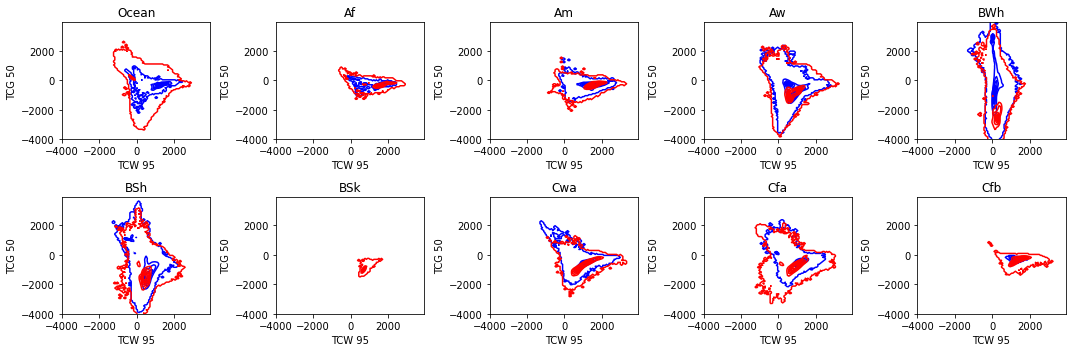

In [48]:
n_zones = len(koppen_hist_w_w95g50)
assert n_zones == 10  # Just for the subplot shapes :)
fig = plt.figure(figsize=(15, 5))
for i, zone in enumerate(sorted(koppen_hist_w_w95g50)):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(climate_zone_labels[zone])
    ax.contour(bins[:-1], bins[:-1], koppen_hist_w_w95g50[zone], colors='blue')
    ax.contour(bins[:-1], bins[:-1], koppen_hist_nw_w95g50[zone], colors='red')
    ax.set_xlabel('TCW 95')
    ax.set_ylabel('TCG 50')
plt.tight_layout()

Let's repeat this with MrVBF.

In [56]:
def get_mrvbf(tile_label):
    mrvbf_path_base = mrvbf_base_path = '/g/data/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_{}.nc'
    mrvbf_path = mrvbf_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_dataset(mrvbf_path)
    return da

In [67]:
def proc_tile_2d_mrvbf(tile_label, tcs, bands, bins):
    hist_wetland = {}
    hist_nonwetland = {}

    # Split up by MrVBF value.
    das = []
    mask_ws = []
    mask_nws = []
    for tc, band in zip(tcs, bands):
        da, mask_w, mask_nw = get_tc_data_and_mask(tile_label, tc=tc, band=band)
        das.append(da)
        mask_ws.append(mask_w)
        mask_nws.append(mask_nw)
    # Masks should be the same, unless data are missing.
    mask_w = np.logical_and(*mask_ws)
    mask_nw = np.logical_and(*mask_nws)
    # MrVBF tile will be the same.
    mrvbf_tile = get_mrvbf(tile_label).band1.isel(time=0)
    mrvbf_vals = np.arange(9)
    
    xs = das[0].isel(band=bands[0]).values
    ys = das[1].isel(band=bands[1]).values
    
    for v in mrvbf_vals:
        vmask_w = mask_w & (mrvbf_tile == v)
        hist_wetland[v] = np.histogram2d(xs[vmask_w], ys[vmask_w], bins=(bins, bins))[0]
        vmask_nw = mask_nw & (mrvbf_tile == v)
        hist_nonwetland[v] = np.histogram2d(xs[vmask_nw], ys[vmask_nw], bins=(bins, bins))[0]

    return hist_wetland, hist_nonwetland

def mrvbf_hist_2d(tcs=('w', 'g'), bands=(3, 1), bins=None):
    if bins is None:
        bins = np.linspace(-4000, 4000, 120)
    
    with Pool(4) as pool:
        params = [(t.label, tcs, bands, bins) for t in tiles.itertuples()]
        results = [pool.apply_async(proc_tile_2d_mrvbf, p) for p in params]
        # pool.map fails in a notebook environment.
        hist_results = [r.get() for r in tqdm(results)]
    
    hist_wetland, hist_nonwetland = {}, {}
    for rw, rnw in hist_results:
        for k, v in rw.items():
            if k in hist_wetland:
                hist_wetland[k] += v
            else:
                hist_wetland[k] = v
        for k, v in rnw.items():
            if k in hist_nonwetland:
                hist_nonwetland[k] += v
            else:
                hist_nonwetland[k] = v
    
    return hist_wetland, hist_nonwetland

In [68]:
bins = np.linspace(-4000, 4000, 120)
mrvbf_hist_w_w95g50, mrvbf_hist_nw_w95g50 = mrvbf_hist_2d(bins=bins)

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

7115.0

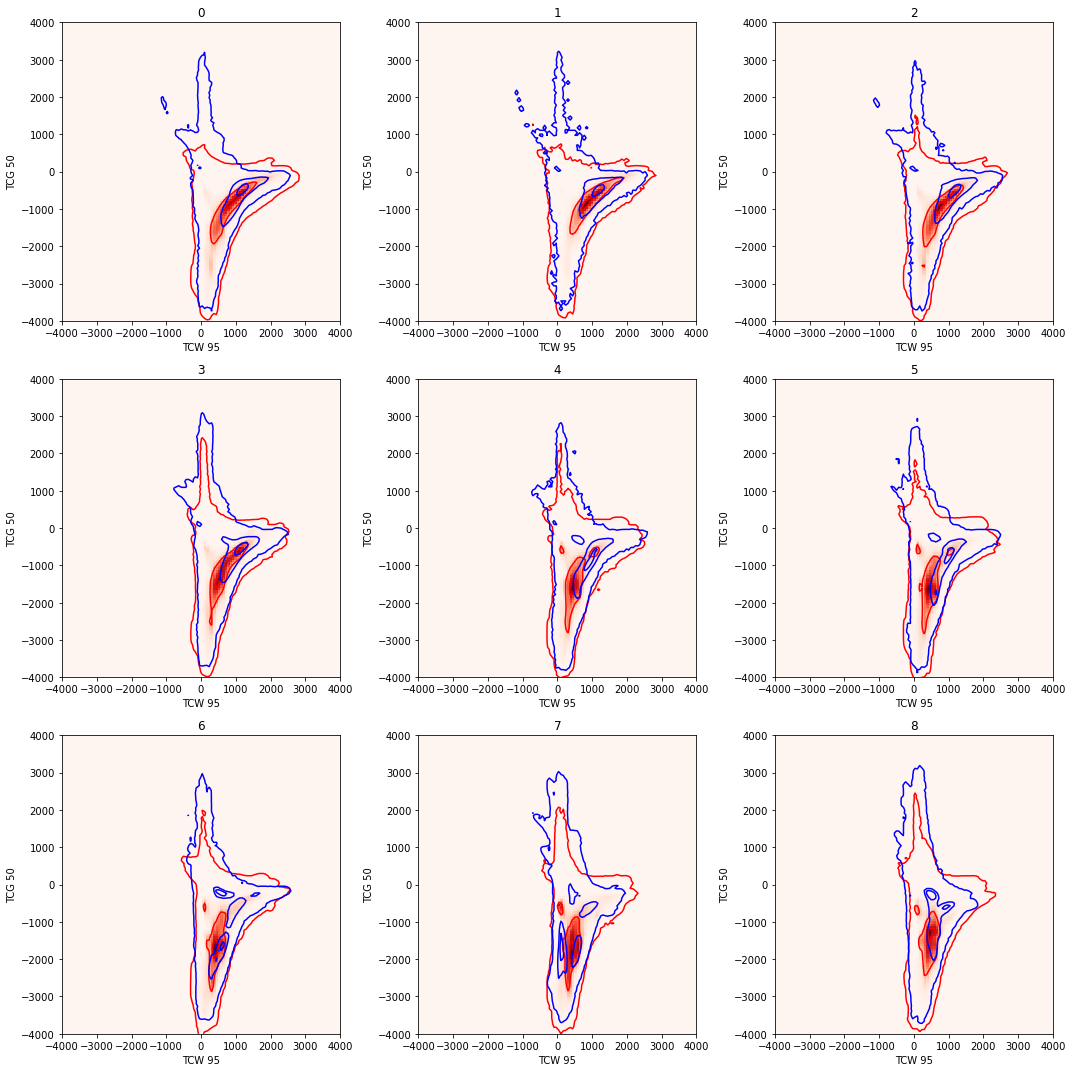

In [102]:
n_zones = len(mrvbf_hist_w_w95g50)
assert n_zones == 9
fig = plt.figure(figsize=(15, 15))
for i, zone in enumerate(sorted(mrvbf_hist_w_w95g50)):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title(zone)
    ax.pcolormesh(bins, bins, mrvbf_hist_nw_w95g50[zone], cmap='Reds')#, norm=matplotlib.colors.SymLogNorm(1, base=10))
    cntr = ax.contour(bins[:-1], bins[:-1], mrvbf_hist_nw_w95g50[zone], colors='red',
               levels=np.percentile(mrvbf_hist_nw_w95g50[zone], [90, 99, 99.9]))
    cntr = ax.contour(bins[:-1], bins[:-1], mrvbf_hist_w_w95g50[zone], colors='blue',
               levels=np.percentile(mrvbf_hist_w_w95g50[zone], [90, 99, 99.9]))
    ax.set_xlabel('TCW 95')
    ax.set_ylabel('TCG 50')
plt.tight_layout()
plt.savefig('mrvbf.png')

Gabrielle wants a scatter plot, so here's one for one tile.

In [116]:
def plot_tile_2d_mrvbf_scatter(tile_label, tcs, bands):
    # Split up by MrVBF value.
    das = []
    mask_ws = []
    mask_nws = []
    for tc, band in zip(tcs, bands):
        da, mask_w, mask_nw = get_tc_data_and_mask(tile_label, tc=tc, band=band)
        das.append(da)
        mask_ws.append(mask_w)
        mask_nws.append(mask_nw)
    # Masks should be the same, unless data are missing.
    mask_w = np.logical_and(*mask_ws)
    mask_nw = np.logical_and(*mask_nws)
    # MrVBF tile will be the same.
    mrvbf_tile = get_mrvbf(tile_label).band1.isel(time=0)
    mrvbf_vals = np.arange(10)
    
    xs = das[0].isel(band=bands[0]).values
    ys = das[1].isel(band=bands[1]).values
    
    plt.figure(figsize=(10, 10))
    for v in mrvbf_vals:
        ax = plt.subplot(3, 3, 1 + v)
        vmask_w = mask_w & (mrvbf_tile == v)
        ax.scatter(xs[vmask_w], ys[vmask_w], c='blue', s=1, alpha=0.1, edgecolor='None')
        vmask_nw = mask_nw & (mrvbf_tile == v)
        ax.scatter(xs[vmask_nw], ys[vmask_nw], c='red', s=1, alpha=0.1, edgecolor='None')

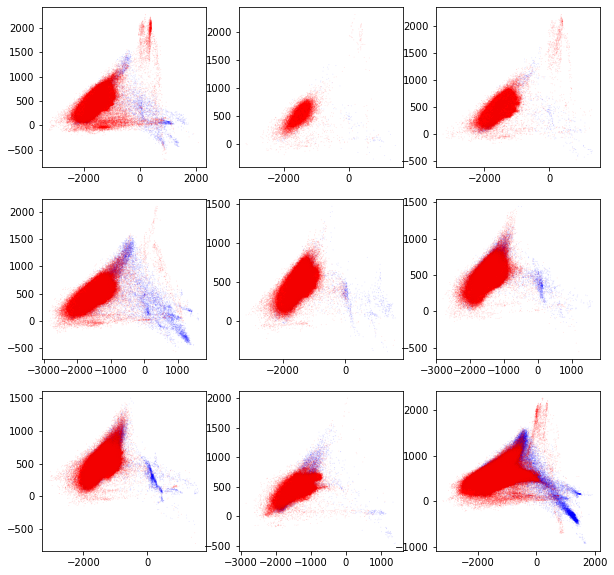

In [117]:
plot_tile_2d_mrvbf_scatter(tiles.label[4], ('w', 'g'), (3, 1))

In [118]:
plt.savefig('mrvbf2.png')

<Figure size 432x288 with 0 Axes>

Do these values provide any separating power at all? It would be useful to have a single number that describes "separability" somehow. Let's provide the logistic regression loss to represent this number, as this directly tells us the linear separability of the dataset.

Note that we probably want something "nonlinear" in reality since MrVBF seems to be useful to inform thresholds. A simple method for doing this while still being fast and interpretable would be having a separate logistic regression for each MrVBF band.

In [103]:
import sklearn.linear_model

In [119]:
tcw = get_tcw(tiles.label[4])
tcg = get_tcg(tiles.label[4])

In [123]:
mrvbf = get_mrvbf(tiles.label[4])

In [135]:
features = np.stack([tcw.isel(band=i) for i in range(4)] + [tcg.isel(band=i) for i in range(4)] + [mrvbf.band1.isel(time=0)])
features = features.transpose(1, 2, 0)

In [129]:
labels = make_wetland_mask(tcw.isel(band=0))

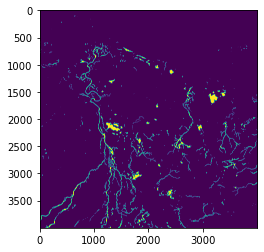

In [131]:
plt.imshow(labels)

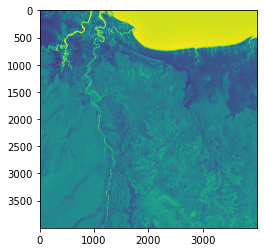

In [138]:
plt.imshow(features[:, :, 0])